## Step 5: Let's look at some stats 👀

In [1]:
import pandas as pd
import geopandas as gpd

# URL parser
import tldextract

# For plotting
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(context='notebook', style='whitegrid', palette='bright')

In [3]:
final = gpd.read_file('./final/final.full.gpkg')

In [4]:
final.shape

(1416, 26)

## Quick stats

In [5]:
top_countries = final.country.value_counts()
top_countries

country
France            710
Austria           164
Germany           133
Switzerland       116
Italy              81
Belgium            38
Slovenia           28
Slovakia           26
United Kingdom     21
Czechia            19
Ukraine            16
Hungary            14
Russia             13
Netherlands        11
United States       6
Sweden              4
Portugal            4
Norway              3
Romania             2
Chile               2
Nicaragua           1
Morocco             1
Croatia             1
Australia           1
Liechtenstein       1
Name: count, dtype: int64

In [6]:
top_countries.shape

(25,)

In [7]:
top_languages = final.description_lang.value_counts().head(20)
top_languages

description_lang
fr    802
de    330
en    110
it     62
sl     27
sk     22
ru     19
cs     16
hu     11
nl      9
uk      8
Name: count, dtype: int64

### What are the top domains of sourced GPX files?

In [8]:
def get_domain(url):
    x = tldextract.extract(url)
    return f'{x.domain}.{x.suffix}'

final['domain'] = final.url.apply(get_domain)

In [9]:
final.domain.value_counts()

domain
apidae-tourisme.com      296
tourinsoft.eu            172
vorarlberg.travel        157
expemag.com              100
toursprung.com            62
                        ... 
vagabondcurieux.fr         1
seine-saintgermain.fr      1
dbgktrails.hu              1
litomysl.cz                1
relaisduvisiteur.be        1
Name: count, Length: 135, dtype: int64

In [10]:
m2ft = lambda m: m * 3.28084
m2mi = lambda m: m * 0.0006213712

### What is the track length?

In [11]:
print('Min length: ', round(final.length_2d.min()), 'm; in ft:', m2ft(round(final.length_2d.min())))
print('Mean length: ', round(final.length_2d.mean()), 'm; in km:', m2mi(round(final.length_2d.mean())))
print('Median length: ', round(final.length_2d.median()), 'm; in km:', m2mi(round(final.length_2d.median())))
print('Max length: ', round(final.length_2d.max()), 'm; in km:', m2mi(round(final.length_2d.max())))

Min length:  607 m; in ft: 1991.4698799999999
Mean length:  20506 m; in km: 12.7418378272
Median length:  12082 m; in km: 7.5074068384
Max length:  99250 m; in km: 61.6710916


### Description length - original

In [12]:
print('Min description length:', final.description.str.len().min())
print('Avg description length:', final.description.str.len().mean())
print('Median description length:', final.description.str.len().median())
print('Max description length:', final.description.str.len().max())

Min description length: 50
Avg description length: 461.94632768361583
Median description length: 303.0
Max description length: 1999


### Description length - translated to Eng

In [13]:
print('Min description length:', final.description_en.str.len().min())
print('Avg description length:', final.description_en.str.len().mean())
print('Median description length:', final.description_en.str.len().median())
print('Max description length:', final.description_en.str.len().max())

Min description length: 34
Avg description length: 434.08121468926555
Median description length: 285.5
Max description length: 1866


## Let's plot! 🎨

In [14]:
plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.pad_inches"] = 0

In [15]:
def plot_barh(series, title):
    
    axes = series.plot(
        kind='barh',
        figsize=(3.0,3.0),
        title=title,
        color='black',
        legend=False
    )


def plot_hist(series, title):
    
    axes = series.plot(
        kind='hist',
        figsize=(3.0,3.0),
        title=title,
        color='black',
        legend=False,
        bins=20
    )

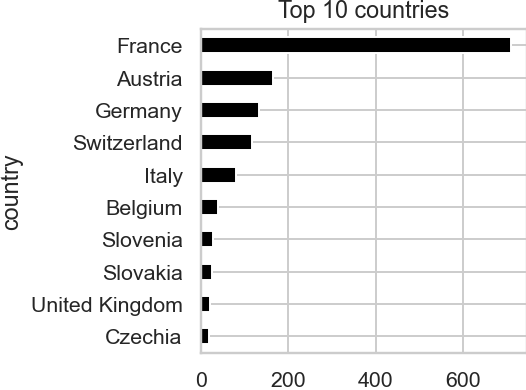

In [16]:
plot_barh(final.country.value_counts().head(10)[::-1], 'Top 10 countries')

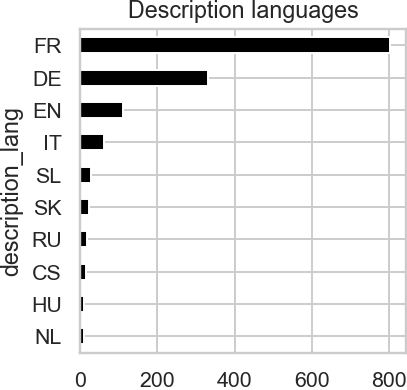

In [17]:
plot_barh(
    final.description_lang.str.upper().value_counts().head(10)[::-1],
    'Description languages'
)

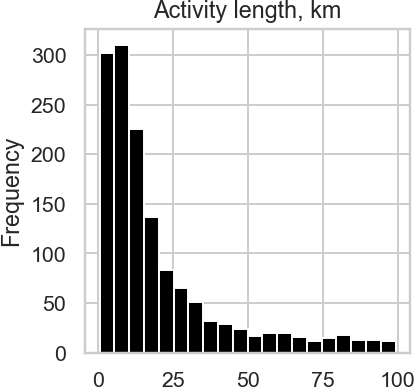

In [18]:
plot_hist(final.length_2d / 1000, 'Activity length, km')

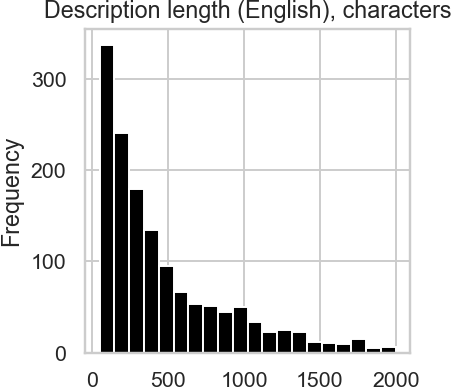

In [19]:
plot_hist(final.description.str.len(), 'Description length (English), characters')

### Plot actual routes

In [20]:
def get_map(n, zoom_adjust=-1, buff_size=(200, 200)):
    
    ax = (
        final.iloc[n:n+1]
        .to_crs(3857)
        .plot(
            color='blue',
            figsize=(4,4)
        )
    )
    
    # Add some buffer space
    xlim = list(ax.get_xlim())
    xlim[0] -= buff_size[0]
    xlim[1] += buff_size[0]

    ylim = list(ax.get_ylim())
    ylim[0] -= buff_size[1]
    ylim[1] += buff_size[1]

    # Update limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Remove axes
    ax.set_axis_off()

    # Add basemap
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom_adjust=zoom_adjust)

    # Print descriptions + stats
    print('Original description:', final.iloc[n].description)
    print('Description language:', final.iloc[n].description_lang)
    print('English translation:', final.iloc[n].description_en)
    print('Length (km):', round(final.iloc[n].length_2d / 1000, 1))
    print('Country:', final.iloc[n].country)

Original description: Der Weg ist sehr gut gekennzeichnet mit einem schwarzen Hirschkäfer (Hootzemann) auf weißem Grund. Mein Start- und Zielpunkt war das Schützenhaus Eiweiler in der Nähe der Großwald-Brauerei.
Description language: de
English translation: The path is very well marked with a black deer beetle (Hootzemann) on white ground. My starting and finishing point was the Schützenhaus Eiweiler near the Großwald brewery.
Length (km): 13.8
Country: Germany


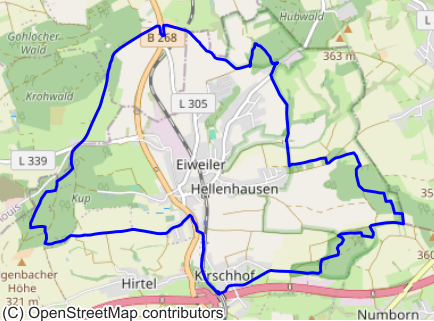

In [21]:
germany_idx = final[final.description.str.contains('Hootzemann')].index[0]
get_map(germany_idx)

Original description: Longbridge to Whalley Slowway following part of the Ribble Way. Difficult to find a good crossing of the A59. The crossing chosen crosses the road from footpath to footpath in a place with good visibility. The road junctions/bridges were actually worse as would need to walk along a fast road with no pavement rather than just cross once at right angles. This crossing sets up good sections without roads. Good spacing of waypoints at Old Langho and Ribchester.
Description language: en
English translation: Longbridge to Whalley Slowway following part of the Ribble Way. Difficult to find a good crossing of the A59. The crossing chosen crosses the road from footpath to footpath in a place with good visibility. The road junctions/bridges were actually worse as would need to walk along a fast road with no pavement rather than just cross once at right angles. This crossing sets up good sections without roads. Good spacing of waypoints at Old Langho and Ribchester.
Length (

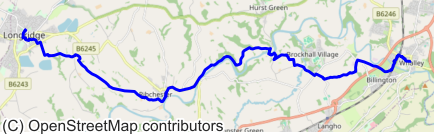

In [22]:
uk_idx = final[final.description_en.str.contains('Whalley Slowway')].index[0]
get_map(uk_idx, zoom_adjust=0, buff_size=(200, 1500))